# 単層CNNによるMNISTの手書き数字認識
http://tensorflow.classcat.com/2016/03/09/tensorflow-cc-mnist-for-ml-beginners/

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data
import seaborn as sns
import tensorflow as tf
import mytfext
%matplotlib inline

※ tensorflow にはMNISTのサンプルデータをダウンロードするためのモジュールが備わっている

In [2]:
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


# モデルの定義

In [113]:
# モデルの作成
np.random.seed(19601228)
tf.set_random_seed(19601228)

# このモデルではフィルタの出力を直接NNのsoftmax出力につないでいるので num_units は使っていないが、次の発展のために用意してある。
class NN:
    def __init__(self, num_filters, num_units,learning_rate=0.001):
        with tf.Graph().as_default():
            self.model(num_filters,num_units,learning_rate)
            self.session()
    
    def model(self, num_filters, num_units,learning_rate=0.001):
        with tf.name_scope("filters"):
            img = tf.placeholder(tf.float32,[None,784], name="input")
            tf_image = tf.reshape(img, [-1,28,28,1])
            
            W_conv = tf.Variable(tf.truncated_normal([5,5,1,num_filters],stddev=0.1), name="cnv2d_filter")
            h_conv = tf.nn.conv2d(tf_image, W_conv, strides=[1,1,1,1], padding="SAME", name="filtered")
            h_pool = tf.nn.max_pool(h_conv, ksize=[1,4,4,1],strides=[1,4,4,1], padding="SAME", name="pooled")
            num_Punits =7*7*num_filters
            h_pool_fl = tf.reshape(h_pool, [-1,num_Punits], name="flatten_pool")
            
        with tf.name_scope("hidden"):
            whdn = tf.Variable(tf.truncated_normal([num_Punits, num_units]))
            bhdn = tf.Variable(tf.truncated_normal([num_units]))
            hhdn = tf.nn.relu(tf.matmul(h_pool_fl,whdn)+bhdn, name="hidden-output")
            
        with tf.name_scope("output"):
            wOut = tf.Variable(tf.zeros([num_units, 10]))
            bOut = tf.Variable(tf.zeros([10]))
            out = tf.nn.softmax(tf.matmul(hhdn,wOut)+bOut, name="softmax-output")
            
        with tf.name_scope("Optimizer") as scope:
            ideal = tf.placeholder(tf.float32, [None, 10], name="ideal")
            loss = -tf.reduce_sum(ideal*tf.log(out), name="loss")
            # train_step = tf.train.GradientDescentOptimizer(0.00002).minimize(loss)
            train_step = tf.train.AdamOptimizer(learning_rate).minimize(loss)
        
        with tf.name_scope("Evaluator") as scope:
            correct_prediction = tf.equal(tf.argmax(out,1),tf.argmax(ideal,1), name="correct")
            accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name="accuracy")
            
            
        tf.summary.scalar("loss", loss)
        tf.summary.scalar("accuracy", accuracy)
        tf.summary.histogram("filter_matrix", W_conv)
        
        self.img, self.ideal, self.out = img, ideal, out
        self.train_step = train_step
        self.loss, self.accuracy = loss, accuracy
        
        self.W_conv = W_conv
        self.h_conv = h_conv
        self.h_pool = h_pool
        
    def session(self):
        sess = tf.InteractiveSession()
        sess.run(tf.global_variables_initializer())
        saver = tf.train.Saver()
        
        # sess.run(tf.local_variables_initializer())
        summary = tf.summary.merge_all()
        writer = tf.summary.FileWriter("log7", sess.graph)
                               
        self.sess = sess
        self.summary = summary
        self.writer = writer
        self.saver = saver

# セッションの開始

In [37]:
nn.sess.close()
!rmdir "log7"

In [140]:
nn = NN(16,392,learning_rate=0.001)

In [141]:
times = 0
for _ in range(2000):
    times += 1
    batch_xs,batch_ts = mnist.train.next_batch(100)
    nn.sess.run(nn.train_step, feed_dict={nn.img:batch_xs, nn.ideal:batch_ts})
    if times % 100 == 0:
        summary,loss_val, acc_val = nn.sess.run([nn.summary,nn.loss,nn.accuracy],
                feed_dict={nn.img:mnist.test.images, nn.ideal:mnist.test.labels})
        print("Step: {0:d}, Loss: {1:f}, Accuracy: {2:f}".format(times, loss_val, acc_val))
        nn.writer.add_summary(summary,times)
        nn.saver.save(nn.sess, '.\mysession', global_step = times)

Step: 100, Loss: 2106.511475, Accuracy: 0.938400
Step: 200, Loss: 1291.386230, Accuracy: 0.959300
Step: 300, Loss: 1036.819580, Accuracy: 0.966600
Step: 400, Loss: 1134.818115, Accuracy: 0.961200
Step: 500, Loss: 790.035889, Accuracy: 0.975400
Step: 600, Loss: 730.405029, Accuracy: 0.975300
Step: 700, Loss: 696.545166, Accuracy: 0.976900
Step: 800, Loss: 656.618469, Accuracy: 0.978300
Step: 900, Loss: 633.796204, Accuracy: 0.979100
Step: 1000, Loss: 526.738892, Accuracy: 0.982100
Step: 1100, Loss: 550.864502, Accuracy: 0.981100
Step: 1200, Loss: 559.555115, Accuracy: 0.981300
Step: 1300, Loss: 539.317017, Accuracy: 0.981400
Step: 1400, Loss: 554.734253, Accuracy: 0.982000
Step: 1500, Loss: 593.418762, Accuracy: 0.979700
Step: 1600, Loss: 464.937775, Accuracy: 0.984700
Step: 1700, Loss: 589.920532, Accuracy: 0.981000
Step: 1800, Loss: 548.911621, Accuracy: 0.981800
Step: 1900, Loss: 467.676392, Accuracy: 0.984400
Step: 2000, Loss: 435.434326, Accuracy: 0.985600


In [142]:
nn = NN(16,784,learning_rate=0.001)

In [143]:
times = 0
for _ in range(2000):
    times += 1
    batch_xs,batch_ts = mnist.train.next_batch(100)
    nn.sess.run(nn.train_step, feed_dict={nn.img:batch_xs, nn.ideal:batch_ts})
    if times % 100 == 0:
        summary,loss_val, acc_val = nn.sess.run([nn.summary,nn.loss,nn.accuracy],
                feed_dict={nn.img:mnist.test.images, nn.ideal:mnist.test.labels})
        print("Step: {0:d}, Loss: {1:f}, Accuracy: {2:f}".format(times, loss_val, acc_val))
        nn.writer.add_summary(summary,times)
        nn.saver.save(nn.sess, '.\mysession', global_step = times)

Step: 100, Loss: 1802.535156, Accuracy: 0.949200
Step: 200, Loss: 1203.021240, Accuracy: 0.961900
Step: 300, Loss: 931.582520, Accuracy: 0.972600
Step: 400, Loss: 735.615845, Accuracy: 0.975600
Step: 500, Loss: 672.210205, Accuracy: 0.978800
Step: 600, Loss: 669.003845, Accuracy: 0.978500
Step: 700, Loss: 638.011597, Accuracy: 0.979100
Step: 800, Loss: 717.529297, Accuracy: 0.976700
Step: 900, Loss: 573.764282, Accuracy: 0.980900
Step: 1000, Loss: 561.660339, Accuracy: 0.982600
Step: 1100, Loss: 620.398376, Accuracy: 0.980900
Step: 1200, Loss: 522.648804, Accuracy: 0.982900
Step: 1300, Loss: 452.209351, Accuracy: 0.984000
Step: 1400, Loss: 469.706207, Accuracy: 0.983200
Step: 1500, Loss: 406.959839, Accuracy: 0.986800
Step: 1600, Loss: 426.905151, Accuracy: 0.985500
Step: 1700, Loss: 498.767975, Accuracy: 0.983800
Step: 1800, Loss: 391.061371, Accuracy: 0.987800
Step: 1900, Loss: 404.186462, Accuracy: 0.986500
Step: 2000, Loss: 392.788147, Accuracy: 0.987400


# 98.7%!

# 学習結果を用いて文字認識してみる

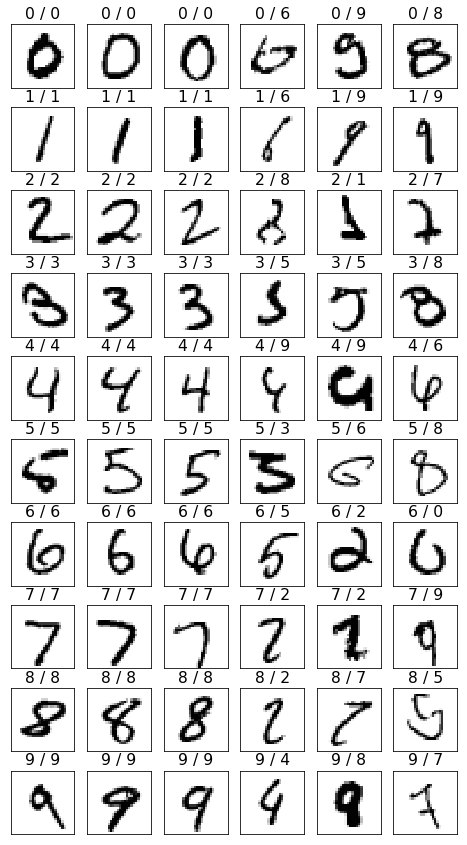

In [144]:
plt.figure(figsize=(8,15))
def plotchr(image,label1,label2, i):
    sns.set_context("talk")
    plt.subplot(10,6,i)
    plt.xticks([])
    plt.yticks([])
    plt.title("%d / %d" % (np.argmax(label1),np.argmax(label2)))
    plt.imshow(image,cmap=plt.cm.gray_r)
    
images, labels = mnist.test.images, mnist.test.labels
p_val = nn.sess.run(nn.out, feed_dict={nn.img:images, nn.ideal:labels})

# 0～9 と判定されたものについて、それぞれ正の例を３つ、負の例を３つ表示する
picnumber = 0
for i in range(10):
    c = 0
    for (image, label, pred) in zip(images, labels, p_val):
        prediction,actual = np.argmax(pred), np.argmax(label)
        if prediction != i:  # 
            continue
        if(c<3 and i == actual) or (c>=3 and i != actual):
            picnumber += 1
            plotchr(image.reshape((28,28)),pred,label,picnumber)
            c += 1
            if c > 5:
                break
            

In [145]:
num_filters=16

def showFilterEffect(num_filters, start, filters,imgs):
    fig = plt.figure(figsize=(10,num_filters+1))
    for i in range(num_filters):
        subplot = fig.add_subplot(num_filters+1, 10, 10*(i+1)+1)
        sns.heatmap(filters[:,:,0,i],yticklabels=[],xticklabels=[],
                cmap=plt.cm.bwr,cbar=False,annot=False,square=True)

    for i in range(9):
        subplot = fig.add_subplot(num_filters+1, 10, i+2)
        oimg = mnist.test.images[start+i].reshape((28,28))
        title = '{:d}'.format(np.argmax(mnist.test.labels[start+i]))
        subplot.set_title(title)
        sns.heatmap(oimg,yticklabels=[],xticklabels=[],
                cmap=plt.cm.binary,cbar=False,annot=False,square=True)

        for f in range(num_filters):
            subplot = fig.add_subplot(num_filters+1, 10, 10*(f+1)+i+2)
            sns.heatmap(imgs[i][:,:,f],yticklabels=[],xticklabels=[],
                cmap=plt.cm.binary,cbar=False,annot=False,square=True)

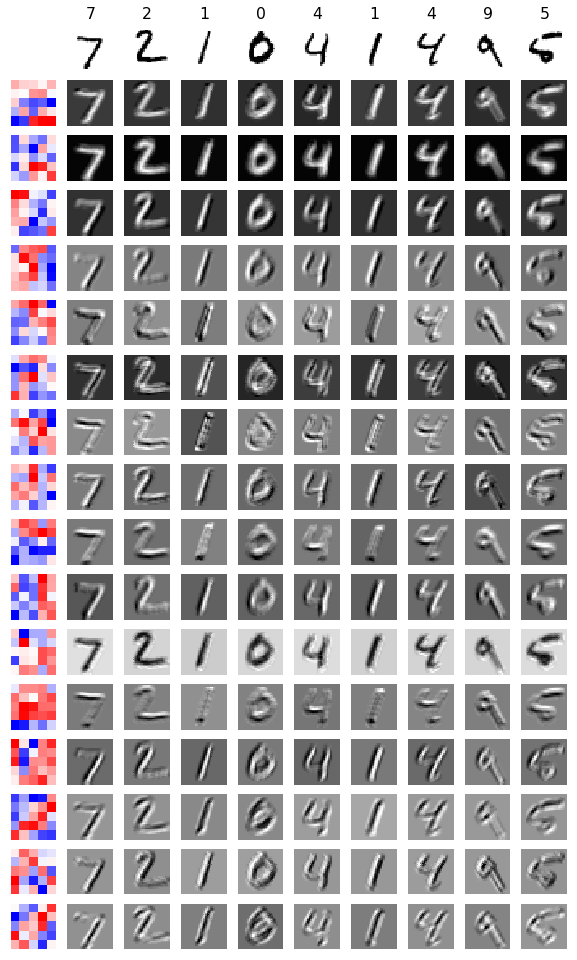

In [146]:
filter_vals, conv_vals, pool_vals = nn.sess.run(
    [nn.W_conv, nn.h_conv, nn.h_pool], feed_dict={nn.img:mnist.test.images[0:10]})
showFilterEffect(16,0,filter_vals,conv_vals)

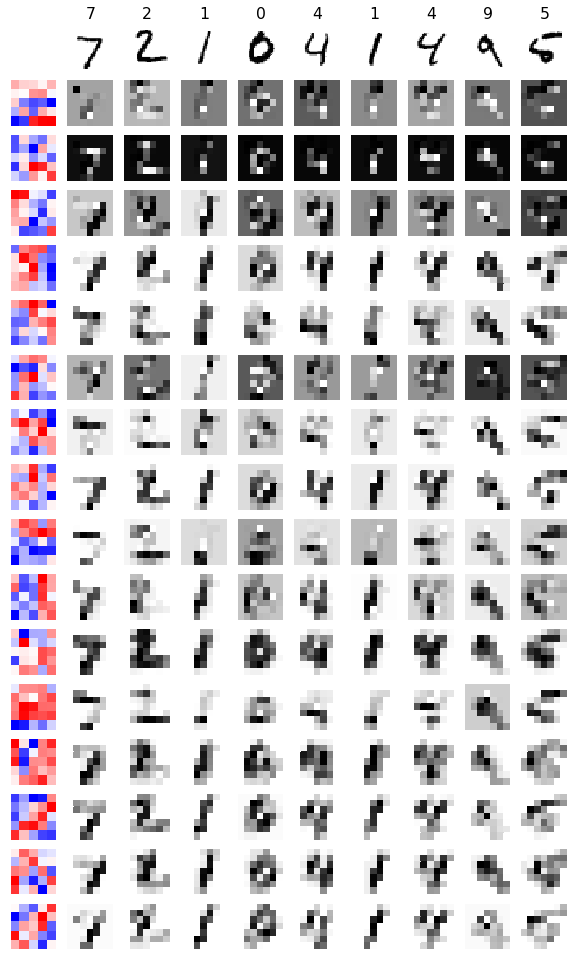

In [147]:
showFilterEffect(16,0,filter_vals,pool_vals)

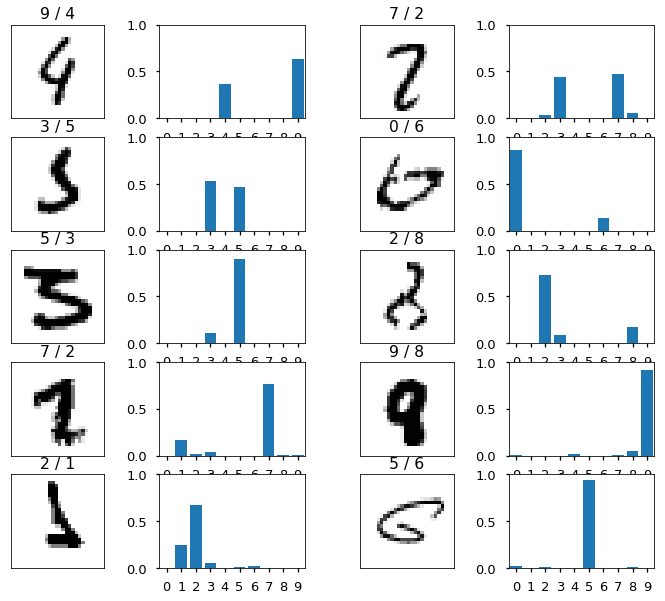

In [148]:
fig = plt.figure(figsize=(12,10))
c=0
for i in range(len(mnist.test.images)):
    image = mnist.test.images[i:i+1]
    label = mnist.test.labels[i]
    p_val = nn.sess.run(nn.out, feed_dict={nn.img:image})
    pred = p_val[0]
    prediction, actual = np.argmax(pred), np.argmax(label)
    if prediction == actual:
        continue
    subplot = fig.add_subplot(5,4,c*2+1)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.set_title('{} / {}'.format(prediction, actual))
    subplot.imshow(image.reshape((28,28)), vmin=0, vmax=1,
                   cmap=plt.cm.binary, interpolation="nearest")
    subplot = fig.add_subplot(5,4,c*2+2)
    subplot.set_xticks(range(10))
    subplot.set_xlim(-0.5,9.5)
    subplot.set_ylim(0,1)
    subplot.bar(range(10), pred, align='center')
    c += 1
    if c == 10:
        break